# Entrenamiento múltiple

## Especificamos nuestra carpeta de trabajo

In [10]:
!mkdir modelos

In [11]:
workdir = '/tf/modelos/'
workdir_datasets = '/tf/DATASETS/'
!ls -la $workdir

total 8
drwxr-xr-x  2 root root 4096 Mar 28 10:08 .
drwxr-x--- 14 root root 4096 Mar 28 10:08 ..


## Instalamos las librerías que necesitaremos

In [26]:
!pip install -q tflite-model-maker
!pip install -q tensorflow
!pip install -q tensorflow-addons

## Importamos las librerías que vamos a usar

In [27]:
import numpy as np
from numpy.random import RandomState
import pandas as pd
import os
#from google.colab import files # Para descargar archivos desde Google Colab

import tensorflow_addons as tfa

from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.text_classifier import AverageWordVecSpec
from tflite_model_maker.text_classifier import BertClassifierSpec
from tflite_model_maker.text_classifier import MobileBertClassifierSpec
from tflite_model_maker.text_classifier import DataLoader

# Para ahorrarnos el tokenizer manual :)
from tflite_support.task.text import NLClassifier
from tflite_support.task.text import NLClassifierOptions
import tflite_support

import numpy as np
import pandas as pd
import re
import datetime

import json
import xlsxwriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')

## Recogemos los datasets

In [6]:
!curl -s https://raw.githubusercontent.com/Text-Analysis-Android-Apps/Custom-Text-Classification-on-Android-using-TF-Lite/master/train.csv > "$workdir_datasets"train_en.csv
!curl -s https://raw.githubusercontent.com/Text-Analysis-Android-Apps/Custom-Text-Classification-on-Android-using-TF-Lite/master/test.csv > "$workdir_datasets"test_en.csv

## Los importamos a Pandas

In [13]:
df_train_en = pd.read_csv(workdir_datasets+'train_en.csv', error_bad_lines=False, engine="python")
df_test_en = pd.read_csv(workdir_datasets+'test_en.csv', error_bad_lines=False, engine="python")


<ipython-input-13-f2749630dde0>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_train_en = pd.read_csv(workdir_datasets+'train_en.csv', error_bad_lines=False, engine="python")
<ipython-input-13-f2749630dde0>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_test_en = pd.read_csv(workdir_datasets+'test_en.csv', error_bad_lines=False, engine="python")


## Procesamos el dataset inglés

In [22]:
df_test_en['label'] = df_test_en['label'].str.replace('Non-offensive', 'Non-Offensive')

### Vemos su tamaño

In [23]:
df_train_en.groupby('label').size()

label
Non-Offensive    350
Offensive        350
dtype: int64

In [24]:
df_test_en.groupby('label').size()

label
Non-Offensive    150
Offensive        150
dtype: int64

## Exportamos los datasets procesados a csv

In [ ]:
df_train_en.to_csv(workdir_datasets+'final_train_en.csv', index=True, sep='\t')
df_test_en.to_csv(workdir_datasets+'final_test_en.csv', index=True, sep='\t')

## Especificamos los idiomas y las opciones que se deben usar en un diccionario

In [29]:
defaul_batch_size = 32
opciones_modelos = [
    {'lang': 'en', 'model': 'average_word_vec', 'epochs': 300, 'steps': None, 'batch_size': defaul_batch_size},
    {'lang': 'en', 'model': 'mbert', 'epochs': 3, 'steps': None, 'batch_size': defaul_batch_size}
    ]

## Entrenamos los modelos especificados

In [42]:
hora_comienzo = datetime.datetime.now()
datos_modelos_generados = []
y_preds = []
for modelo in opciones_modelos:
  model_name = "model_" + modelo['model'] + "_" + modelo['lang']
  print("\n\nEntrenando modelo "+modelo['model']+" con dataset "+modelo['lang']+":")
  if (modelo['model'] == 'average_word_vec'):
    spec = model_spec.get('average_word_vec')
  elif (modelo['model'] == 'bert'):
    spec = model_spec.get('bert_classifier')
  elif (modelo['model'] == 'mbert'):
    spec = model_spec.get('mobilebert_classifier')
    #spec.seq_len = 256

  train_data = DataLoader.from_csv(
        filename=workdir_datasets+'final_train_'+modelo['lang']+'.csv',
        delimiter='\t',
        text_column='sentence',
        label_column='label',
        model_spec=spec,
        is_training=True)

  test_data = DataLoader.from_csv(
        filename=workdir_datasets+'final_test_'+modelo['lang']+'.csv',
        delimiter='\t',
        text_column='sentence',
        label_column='label',
        model_spec=spec,
        is_training=False)
  modelo_actual = text_classifier.create(train_data, model_spec=spec, epochs=modelo['epochs'], batch_size=modelo['batch_size'], steps_per_epoch=modelo['steps'])

  # Gráfico del modelo
  print("Mostrando un gráfico del modelo:")
  modelo_actual.summary()
  # Pequeña evaluación
  print("Calculando accuracy y loss final:")
  loss, acc = modelo_actual.evaluate(test_data)

  #modelos_generados.append(modelo_actual)
  print("Exportando modelo...")
  # Se exporta el modelo
  modelo_actual.export(export_dir=workdir, tflite_filename=model_name+'.tflite')
  print("Realizando predicciones y calculando el tiempo medio de inferencia...")

  # Calculamos el tiempo de inferencia de todas las predicciones y lo almacenamos
  tiempo_inicio = datetime.datetime.now()
  y_pred = modelo_actual.predict_top_k(test_data, k=1)
  tiempo_fin = datetime.datetime.now()
  tiempo_inferencia_total = (tiempo_fin - tiempo_inicio).total_seconds()
  print("Las predicciones se han realizado en "+str(tiempo_inferencia_total)+" segundos.")
  y_preds.append(y_pred)

  # Backup de los datos básicos del modelo:
  datos_modelo = {"nombre": model_name, 'tipo': modelo['model'], 'lang': modelo['lang'], 'epochs': modelo['epochs'], 'batch_size': modelo['batch_size'], 'steps': modelo['steps'], 'acc': acc, 'loss': loss, 'tiempo de inferencia total': tiempo_inferencia_total}
  # Backup de los datos del modelo
  with open(workdir+model_name+"-datos.json", "w") as f:
      json.dump(datos_modelo, f)


  datos_modelos_generados.append(datos_modelo)
  print("Se ha generado un modelo de tipo "+datos_modelo['tipo']+", idioma "+datos_modelo['lang']+", con "+str(datos_modelo['epochs'])+" epochs, "+str(datos_modelo['steps'])+" steps y batch_size "+str(datos_modelo['batch_size'])+" con una accuracy de "+str(datos_modelo['acc'])+" y un loss de "+str(datos_modelo['loss']))

  # Backup de los datos predichos
  print("Guardando las predicciones en "+model_name+"-y_pred-train.json...")
  y_pred_aux = []
  for i in range(len(y_pred)):
    y_pred_aux.append((y_pred[i][0][0], float(y_pred[i][0][1])))

  with open(workdir+model_name+"-y_pred-train.json", "w") as f:
      json.dump(y_pred_aux, f)
  print("¡Modelo listo!")

print("\n¡Se ha finalizado el entrenamiento de todos los modelos con éxito!")
hora_final = datetime.datetime.now()
tiempo_inferencia_total = (hora_final - hora_comienzo).total_seconds()
print("Tiempo total de entrenamiento: "+str(tiempo_inferencia_total)+" segundos.")



Entrenando modelo average_word_vec con dataset en:
21/21 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4955
Epoch 2/2
21/21 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5670
Epoch 3/3
21/21 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.6012
Epoch 4/4
21/21 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.6235
Epoch 5/5
21/21 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy: 0.6533
Epoch 6/6
21/21 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.6905
Epoch 7/7
21/21 [==============================] - 0s 6ms/step - loss: 0.6819 - accuracy: 0.7188
Epoch 8/8
21/21 [==============================] - 0s 6ms/step - loss: 0.6795 - accuracy: 0.7277
Epoch 9/9
21/21 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.7753
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6699 - ac

# Evaluación de los modelos

Las dos siguientes celdas generan distintas métricas de cada uno de los modelos y se almacenan en un archivo .json específico de cada modelo. Posteriormente, se unifican todos los datos obtenidos en una tabla en Markdown almacenada en el fichero README.md (para su reresentación en GitHub/GitLab), y en el fichero EvaluacionModelos.xlsx para su representación en Excel.

In [43]:
def etiquetaMarkdown(texto, separador=False):
  if separador:
    return '-' * (len(texto) + 2) + '|'
  else:
    return ' ' + str(texto).replace('\n', '<br>') + ' |'

In [44]:
workbook = xlsxwriter.Workbook(workdir+'EvaluacionModelos.xlsx')
worksheet = workbook.add_worksheet()
bold = workbook.add_format({'bold': True})
markdown_headers = '|'
markdown_separator = '|'
markdown_final = ''
cabeceras = ['Modelo', 'Idioma', 'Tamaño Dataset entrenamiento', 'Tamaño dataset prueba',
             'EPOCHs', 'Steps/EPOCH', 'batch_size', 'Loss', 'Accuracy', 'SKLearn accuracy score', 'SKLearn log loss'
             'SKLearn precision score (micro)', 'SKLearn precision score (macro)', 'SKLearn recall score (micro)',
             'SKLearn recall score (macro)', 'TensorFlowAddons recall (micro)', 'TensorFlowAddons F1 Score (categorias)',
             'TensorFlowAddons F1 Score (micro)', 'TensorFlowAddons F1 Score (macro)', 'SKLearn classification report',
             'Tiempo de medio de inferencia (s)']
for columna in range(len(cabeceras)):
  worksheet.write(0, columna, cabeceras[columna], bold)
  markdown_headers += etiquetaMarkdown(cabeceras[columna])
  markdown_separator += etiquetaMarkdown(cabeceras[columna], True)

markdown_final = markdown_headers + '\n' + markdown_separator + '\n'

i = 1
for modelo in opciones_modelos:
  markdown_modelo = '|'
  model_name = "model_" + modelo['model'] + "_" + modelo['lang']
  backup = {}
  print("Evaluación del modelo "+model_name+": ")

  # Introducimos los valores básicos del modelo
  # Modelo
  if (modelo['model'] == 'average_word_vec'):
    worksheet.write(i, 0, 'Average_word_vector')
    markdown_modelo += etiquetaMarkdown('Average_word_vector')
  elif (modelo['model'] == 'bert'):
    worksheet.write(i, 0, 'BERT')
    markdown_modelo += etiquetaMarkdown('BERT')
  elif (modelo['model'] == 'mbert'):
    worksheet.write(i, 0, 'MobileBERT')
    markdown_modelo += etiquetaMarkdown('MobileBERT')

  # Idioma
  if (modelo['lang'] == 'en'):
    worksheet.write(i, 1, 'Inglés')
    markdown_modelo += etiquetaMarkdown('Inglés')
    worksheet.write(i, 2, '700 (balanceado)')
    markdown_modelo += etiquetaMarkdown('700 (balanceado)')
    worksheet.write(i, 3, '300 (balanceado)')
    markdown_modelo += etiquetaMarkdown('300 (balanceado)')
    df_test = df_test_en

  # EPOCHS
  worksheet.write(i, 4, modelo['epochs'])
  markdown_modelo += etiquetaMarkdown(modelo['epochs'])
  # Steps
  worksheet.write(i, 5, modelo['steps'])
  markdown_modelo += etiquetaMarkdown(modelo['steps'])
  # batch_size
  worksheet.write(i, 6, modelo['batch_size'])
  markdown_modelo += etiquetaMarkdown(modelo['batch_size'])

  # Accuracy y loss
  with open(workdir+model_name+"-datos.json", "r") as f:
    datos = json.load(f)
    worksheet.write(i, 7, datos['loss'])
    markdown_modelo += etiquetaMarkdown(datos['loss'])
    worksheet.write(i, 8, datos['acc'])
    markdown_modelo += etiquetaMarkdown(datos['acc'])


  # Preparamos los datos para la evaluación
  # Restauramos el y_pred guardado anteriormente
  with open(workdir+model_name+"-y_pred-train.json", "r") as f:
      y_pred = json.load(f)

  #Conversión de array de arrays a array de paréntesis
  y_pred_aux = []
  for pred in y_pred:
    y_pred_aux.append([(pred[0], float(pred[1]))])
  y_pred = y_pred_aux

  backup = {}

  # SKLearn

  # Creamos una matriz que represente en una dupla la etiqueta asignada a cada dato (con un 1) de los datos para test
  y_true_sk = []
  for label in df_test['label']:
    if label == 'Non-Offensive':
      y_true_sk.append(0)
    else:
      y_true_sk.append(1)

  y_true_sk = np.array(y_true_sk, np.int32)

  y_pred_sk = y_pred
  # Creamos otra matriz que represente en una dupla la confianza de que un dato tiene cada etiqueta a partir de las predicciones hechas con los datos para test
  y_pred_aux = []
  for obj in y_pred_sk:
    obj = obj[0]
    if obj[0] == 'Non-Offensive':
      y_pred_aux.append(0)
    else:
      y_pred_aux.append(1)

  y_pred_sk = np.array(y_pred_aux, np.int32)



  # TFAdditions

  # Creamos una matriz que represente en una dupla la etiqueta asignada a cada dato (con un 1) de los datos para test
  y_true = []
  for label in df_test['label']:
    if label == 'Non-Offensive':
      y_true.append([1, 0])
    else:
      y_true.append([0, 1])

  y_true = np.array(y_true, np.int32)

  # Creamos otra matriz que represente en una dupla la confianza de que un dato tiene cada etiqueta a partir de las predicciones hechas con los datos para test
  y_pred_aux = []
  for obj in y_pred:
    obj = obj[0]
    if obj[0] == 'Non-Offensive':
      y_pred_aux.append([obj[1], 1 - obj[1]])
    else:
      y_pred_aux.append([1 - obj[1], obj[1]])

  y_pred = np.array(y_pred_aux, np.float32)

  # Métricas:
  res = accuracy_score(y_true_sk, y_pred_sk)
  indice = 'SKLearn accuracy score'
  backup[indice] = str(res)
  worksheet.write(i, 9, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn log loss'
  res = log_loss(y_true_sk, y_pred_sk, eps=1e-15)
  backup[indice] = str(res)
  worksheet.write(i, 10, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn precision score (micro)'
  res = precision_score(y_true_sk, y_pred_sk, average='micro')
  backup[indice] = str(res)
  worksheet.write(i, 11, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn precision score (macro)'
  res = precision_score(y_true_sk, y_pred_sk, average='macro')
  backup[indice] = str(res)
  worksheet.write(i, 12, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn recall score (micro)'
  res = recall_score(y_true_sk, y_pred_sk, average='micro')
  backup[indice] = str(res)
  worksheet.write(i, 13, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn recall score (macro)'
  res = recall_score(y_true_sk, y_pred_sk, average='macro')
  backup[indice] = str(res)
  worksheet.write(i, 14, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'TFAddons recall (micro)'
  metric = tf.keras.metrics.Recall()
  metric.update_state(y_true, y_pred)
  result = metric.result()
  res = result.numpy()
  backup[indice] = str(res)
  worksheet.write(i, 15, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'TFAddons F1 Score (categorias)'
  metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
  metric.update_state(y_true, y_pred)
  result = metric.result()
  res = result.numpy()
  backup[indice] = str(res)
  worksheet.write(i, 16, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'TFAddons F1 Score (micro)'
  metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average='micro')
  metric.update_state(y_true, y_pred)
  result = metric.result()
  res = result.numpy()
  backup[indice] = str(res)
  worksheet.write(i, 17, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'TFAddons F1 Score (macro)'
  metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average='macro')
  metric.update_state(y_true, y_pred)
  result = metric.result()
  res = result.numpy()
  backup[indice] = str(res)
  worksheet.write(i, 18, str(res))
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  indice = 'SKLearn classification report'
  res = classification_report(y_true_sk, y_pred_sk, target_names=['Non-Offensive', 'Offensive'])
  backup[indice] = res
  worksheet.write(i, 19, res)
  markdown_modelo += etiquetaMarkdown(str(res))
  print(indice)
  print(res)

  print(backup)

  with open(workdir+model_name+"-evaluacion.json", "w") as f:
    json.dump(backup, f)

  markdown_final += markdown_modelo + '\n'
  i += 1

workbook.close()
with open(workdir+'README.md', 'w') as f:
    f.write(markdown_final)

Evaluación del modelo model_average_word_vec_en: 
SKLearn accuracy score
0.96
SKLearn log loss
1.3815617170954972
SKLearn precision score (micro)
0.96
SKLearn precision score (macro)
0.9603273438889877
SKLearn recall score (micro)
0.96
SKLearn recall score (macro)
0.96
TFAddons recall (micro)
0.96
TFAddons F1 Score (categorias)
[0.9605263 0.9594595]
TFAddons F1 Score (micro)
0.96
TFAddons F1 Score (macro)
0.9599929
SKLearn classification report
               precision    recall  f1-score   support

Non-Offensive       0.95      0.97      0.96       150
    Offensive       0.97      0.95      0.96       150

     accuracy                           0.96       300
    macro avg       0.96      0.96      0.96       300
 weighted avg       0.96      0.96      0.96       300

{'SKLearn accuracy score': '0.96', 'SKLearn log loss': '1.3815617170954972', 'SKLearn precision score (micro)': '0.96', 'SKLearn precision score (macro)': '0.9603273438889877', 'SKLearn recall score (micro)': '0.96', '

## Para generar gráficas de aprendizaje (antes se ha debido copiar la salida de la celda de entrenamiento en el fichero LogEntrenamiento.txt)

In [45]:
# Cargamos las etiquetas
backup = [
          {'model': "average_word_vec", 'lang': 'en', 'accuracy': [], 'loss': []},
          {'model': "mobilebert", 'lang': 'en', 'accuracy': [], 'loss': []}
         ]
i = -1
skipNextLine = False
with open(workdir+'LogEntrenamiento.txt','r') as f:
    for line in f:
      if skipNextLine:
        skipNextLine = False
        continue
      if "Entrenando modelo " in line:
        i += 1
        #print(line)
      elif "Calculando accuracy y loss final:" in line:
        skipNextLine = True
      elif " - loss: " in line:
        l = line.strip().split(' ')
        loss = float(l[7])
        accuracy = float(l[10])
        backup[i]['accuracy'].append(accuracy)
        backup[i]['loss'].append(loss)
print(backup)

# Lo guardamos en un JSON
with open(workdir+'graficas_entrenamiento.json','w') as f:
  json.dump(backup, f, indent=4)

[{'model': 'average_word_vec', 'lang': 'en', 'accuracy': [0.4955, 0.567, 0.6012, 0.6235, 0.6533, 0.6905, 0.7188, 0.7277, 0.7753, 0.8006, 0.7917, 0.7887, 0.8065, 0.8571, 0.8527, 0.8571, 0.875, 0.8839, 0.881, 0.8914, 0.9092, 0.8943, 0.9122, 0.9167, 0.9077, 0.9137, 0.9182, 0.9196, 0.9182, 0.9241, 0.9345, 0.9271, 0.933, 0.933, 0.9435, 0.933, 0.9449, 0.9539, 0.9539, 0.9494, 0.9658, 0.9479, 0.9554, 0.9673, 0.9494, 0.9628, 0.9658, 0.9554, 0.9673, 0.9628, 0.9673, 0.9792, 0.9747, 0.9807, 0.9821, 0.9836, 0.9717, 0.9792, 0.9777, 0.9836, 0.9851, 0.9866, 0.9881, 0.9881, 0.9821, 0.9881, 0.994, 0.9851, 0.9911, 0.9881, 0.9896, 0.9881, 0.9911, 0.9896, 0.9911, 0.994, 1.0, 0.9955, 0.994, 0.9896, 0.9955, 0.994, 0.9955, 0.997, 0.997, 0.9955, 0.994, 0.997, 0.997, 0.9955, 0.9955, 0.9985, 0.997, 0.9985, 0.997, 0.997, 0.9985, 1.0, 0.997, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 1.0, 1.0, 1.0, 0.9985, 1.0, 0.9955, 1.0, 1.0, 1.0, 0.9985, 0.9985, 1.0, 1.0, 1.0, 1.0, 0.9985, 1.0, 1.0, 1.0, 0.9985, 0.

## Generamos las gráficas de aprendizaje de los distintos modelos durante su entrenamiento

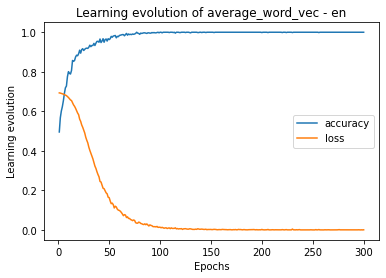

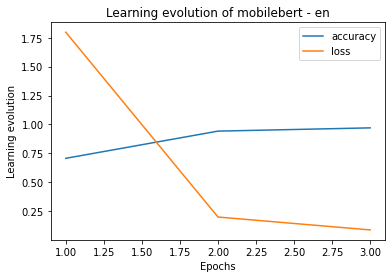

In [46]:
import matplotlib.pyplot as plt
for model in backup:
  x  = range(1, len(model['accuracy'])+1)
  y1 = model['accuracy']
  y2 = model['loss']
  plt.plot(x, y1, label="accuracy")
  plt.plot(x, y2, label="loss")
  plt.plot()

  plt.xlabel("Epochs")
  plt.ylabel("Learning evolution")
  plt.title("Learning evolution of "+model['model']+" - "+model['lang'])
  plt.legend()
  plt.show()